# XgBoostの理解

https://www.kaggle.com/tqchen/understanding-xgboost-model-on-otto-data

# １ introduction

XgBoostは、gradient boosting alogorithmのひとつ。ブラックボックスのように表現されるが、数百、数千の決定木によってそのモデルは作られる。
それを理解して使おう

# 2　Preperation of the data (データの準備)

In [1]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import os
from tempfile import mkstemp
import subprocess
from IPython.display import Image
from IPython.core.display import display
from sklearn.svm import SVC
from sklearn.tree.export import export_graphviz
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot
from xgboost.sklearn import XGBClassifier
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation

C:\Users\Mustang8\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Mustang8\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
import xgboost as xgb
#xgboostの導入

trainデータとtestデータの読み込み（csvファイル）

In [5]:
trainval = pd.read_csv("train.csv")
test = pd.read_csv ('test.csv')

In [7]:
print(trainval.shape)
print(test.shape)

#trainvalとtestデータの次元

(560000, 91)
(361500, 89)


In [12]:
trainval.head(5)

,data_id,period,c1,c2,c3,c4,c5,c6,c7,c8,...,c80,c81,c82,c83,c84,c85,c86,c87,c88,target
0,2,train1,0.655570,-0.000022,-0.000539,-0.001075,0.0,0.0,0.213390,0.0,...,-0.023358,-0.017041,0.0,0.060697,0.0,0.0,0.000000,-0.000202,-0.140220,1
1,3,train1,1.646430,-0.000292,-0.008367,0.009497,0.0,0.0,0.000000,0.0,...,-0.059429,-0.009109,0.0,0.021645,0.0,0.0,0.000000,-0.004382,0.455767,0
2,5,train1,-0.743010,0.004642,-0.000647,-0.003290,0.0,0.0,0.000000,0.0,...,0.001796,-0.000104,0.0,-0.024718,0.0,0.0,0.219566,0.072711,1.155580,0
3,7,train1,0.029770,-0.006343,-0.000635,-0.002516,0.0,0.0,0.160313,0.0,...,-0.005501,0.045308,0.0,-0.148852,0.0,0.0,0.000000,-0.101181,-0.954553,0
4,10,train1,-0.660243,0.012591,-0.002098,-0.022264,0.0,0.0,0.000000,0.0,...,0.029034,-0.005847,0.0,-0.007073,0.0,0.0,0.000000,-0.004842,0.436002,0


In [13]:
test.head(5)

,data_id,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c79,c80,c81,c82,c83,c84,c85,c86,c87,c88
0,1466096,-0.336471,0.001629,-0.005328,0.337606,0.0,0.0,0.0,0.0,0.000779,...,0.078639,-0.121671,-0.007804,0.0,-0.261070,0.0,0.0,0.0,-0.002886,-0.999901
1,1466102,0.023397,0.010739,-0.035836,-0.017537,0.0,0.0,0.0,0.0,-0.003914,...,0.006190,0.071016,-0.008752,0.0,0.072960,0.0,0.0,0.0,-0.043107,1.056089
2,1466110,0.050958,0.012048,-0.004990,0.020966,-0.0,0.0,0.0,0.0,0.016245,...,-0.022399,-0.015489,-0.025594,0.0,0.046554,0.0,0.0,0.0,0.322360,1.506708
3,1466113,-0.123669,0.082726,-0.019575,0.000084,0.0,0.0,0.0,0.0,0.006868,...,0.004039,-0.086416,-0.002464,0.0,0.004583,0.0,0.0,0.0,0.022171,0.653286
4,1466115,1.596477,0.035155,-0.000731,0.028250,0.0,0.0,0.0,0.0,-0.025400,...,-0.056909,0.006886,-0.001491,0.0,0.082378,0.0,0.0,0.0,0.005997,-0.309680


In [22]:
(trainval.target).head(5)

0    1
1    0
2    0
3    0
4    0
Name: target, dtype: int64

このときにデータに文字入っていたら除去したり、静数に変換してデータを整理する

# 3 Model training

学習する前に、誤差の割合を評価するために交差検証を使用する

XGBoostはtrainingデータをtrainデータとvalidデータに分割していく

# 4 Model understanding

In [23]:
TrainVal =pd.DataFrame(trainval)
Test =pd.DataFrame(test)

In [24]:
trainval.columns

Index(['data_id', 'period', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8',
       'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18',
       'c19', 'c20', 'c21', 'c22', 'c23', 'c24', 'c25', 'c26', 'c27', 'c28',
       'c29', 'c30', 'c31', 'c32', 'c33', 'c34', 'c35', 'c36', 'c37', 'c38',
       'c39', 'c40', 'c41', 'c42', 'c43', 'c44', 'c45', 'c46', 'c47', 'c48',
       'c49', 'c50', 'c51', 'c52', 'c53', 'c54', 'c55', 'c56', 'c57', 'c58',
       'c59', 'c60', 'c61', 'c62', 'c63', 'c64', 'c65', 'c66', 'c67', 'c68',
       'c69', 'c70', 'c71', 'c72', 'c73', 'c74', 'c75', 'c76', 'c77', 'c78',
       'c79', 'c80', 'c81', 'c82', 'c83', 'c84', 'c85', 'c86', 'c87', 'c88',
       'target'],
      dtype='object')

In [27]:
feature_name = [ 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8',
       'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18',
       'c19', 'c20', 'c21', 'c22', 'c23', 'c24', 'c25', 'c26', 'c27', 'c28',
       'c29', 'c30', 'c31', 'c32', 'c33', 'c34', 'c35', 'c36', 'c37', 'c38',
       'c39', 'c40', 'c41', 'c42', 'c43', 'c44', 'c45', 'c46', 'c47', 'c48',
       'c49', 'c50', 'c51', 'c52', 'c53', 'c54', 'c55', 'c56', 'c57', 'c58',
       'c59', 'c60', 'c61', 'c62', 'c63', 'c64', 'c65', 'c66', 'c67', 'c68',
       'c69', 'c70', 'c71', 'c72', 'c73', 'c74', 'c75', 'c76', 'c77', 'c78',
       'c79', 'c80', 'c81', 'c82', 'c83', 'c84', 'c85', 'c86', 'c87', 'c88']

#特徴量選択

In [29]:
feature = trainval[feature_name]
y = trainval["target"]
print(feature.shape)
feature.head()

(560000, 88)


,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c79,c80,c81,c82,c83,c84,c85,c86,c87,c88
0,0.655570,-0.000022,-0.000539,-0.001075,0.0,0.0,0.213390,0.0,0.009358,-0.0,...,-0.006942,-0.023358,-0.017041,0.0,0.060697,0.0,0.0,0.000000,-0.000202,-0.140220
1,1.646430,-0.000292,-0.008367,0.009497,0.0,0.0,0.000000,0.0,0.004118,-0.0,...,-0.053761,-0.059429,-0.009109,0.0,0.021645,0.0,0.0,0.000000,-0.004382,0.455767
2,-0.743010,0.004642,-0.000647,-0.003290,0.0,0.0,0.000000,0.0,-0.017536,-0.0,...,0.012014,0.001796,-0.000104,0.0,-0.024718,0.0,0.0,0.219566,0.072711,1.155580
3,0.029770,-0.006343,-0.000635,-0.002516,0.0,0.0,0.160313,0.0,-0.018105,-0.0,...,-0.002345,-0.005501,0.045308,0.0,-0.148852,0.0,0.0,0.000000,-0.101181,-0.954553
4,-0.660243,0.012591,-0.002098,-0.022264,0.0,0.0,0.000000,0.0,-0.004024,-0.0,...,0.008427,0.029034,-0.005847,0.0,-0.007073,0.0,0.0,0.000000,-0.004842,0.436002


In [44]:
X_train, X_valid, y_train, y_valid = cross_validation.train_test_split(feature.values, y.values, test_size=0.2, random_state=0)
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_name)
dvalid = xgb.DMatrix(X_valid, label=y_valid, feature_names = feature_name)
watchlist = [(dtrain,"train"),(dvalid,"valid")]

In [45]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(448000, 88)
(112000, 88)
(448000,)
(112000,)


上記まで、データの整理　cross_validation.train_test_split

xgboostパラメータ設定

In [46]:
xgb_pars = []

MCWlist = [10, 20, 30,40,50]
ETAlist =  [0.05,0.1,0.2,0.3]
CSlist = [0.3,0.5,0.7]
MDlist =  [6,7,8,9,10]
SSlist = [0.5,0.7,0.9]
LAMBDAlist = [0.5,0.6,0.7]

#モデルの複雑さをコントロールするために
#　 　−max_depth, min_child_weight,gamma
#　・ノイズに対する堅牢さを高めるために
#　　sub_sample, colsample_bytree

In [47]:
for MCW in MCWlist:

    for ETA in ETAlist:

        for CS in CSlist:

            for MD in MDlist:
                for SS in SSlist:

                    for LAMBDA in LAMBDAlist:

                        xgb_pars.append({'min_child_weight': MCW, 'eta': ETA, 

                                         'colsample_bytree': CS, 'max_depth': MD,

                                         'subsample': SS, 'lambda': LAMBDA, 

                                         'nthread': -1, 'booster' : 'gbtree', 'eval_metric': 'logloss',

                                         'silent': 1, 'objective': 'binary:logistic'})
patterns = len(MCWlist)*len(ETAlist)*len(CSlist)*len(MDlist)*len(SSlist)*len(LAMBDAlist)
print(patterns)

2700


In [86]:
scores =[]
for i in range(len(xgb_pars)):
    res = model.cv(xgb_pars[i], dtrain, num_boost_round=1000,early_stopping_rounds=50,
                 nfold=5,metrics={'logloss'}, seed = 0,verbose_eval = None)
    scores.append(res.loc[:,"test-logloss-mean"].min())
    print(i/patterns)

    
print("____________________________________")
print("best score")
print(pd.Series(scores).min())
print("best param")
print(xgb_pars[pd.Series(scores).argmin()])

AttributeError: type object 'XGBClassifier' has no attribute 'cv'

In [51]:
xgb_pars = {'min_child_weight': 10, 'eta': 0.05, 'colsample_bytree': 0.3, 'max_depth': 6, 'subsample': 0.9, 
            'lambda': 0.6, 'nthread': -1, 
            'booster': 'gbtree', 'eval_metric': 'logloss', 'silent': 1, 'objective': 'binary:logistic'}

In [59]:
bst = xgb.train(xgb_pars, dtrain, 10, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

[0]	train-logloss:0.692692	valid-logloss:0.692752
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[9]	train-logloss:0.688488	valid-logloss:0.689003


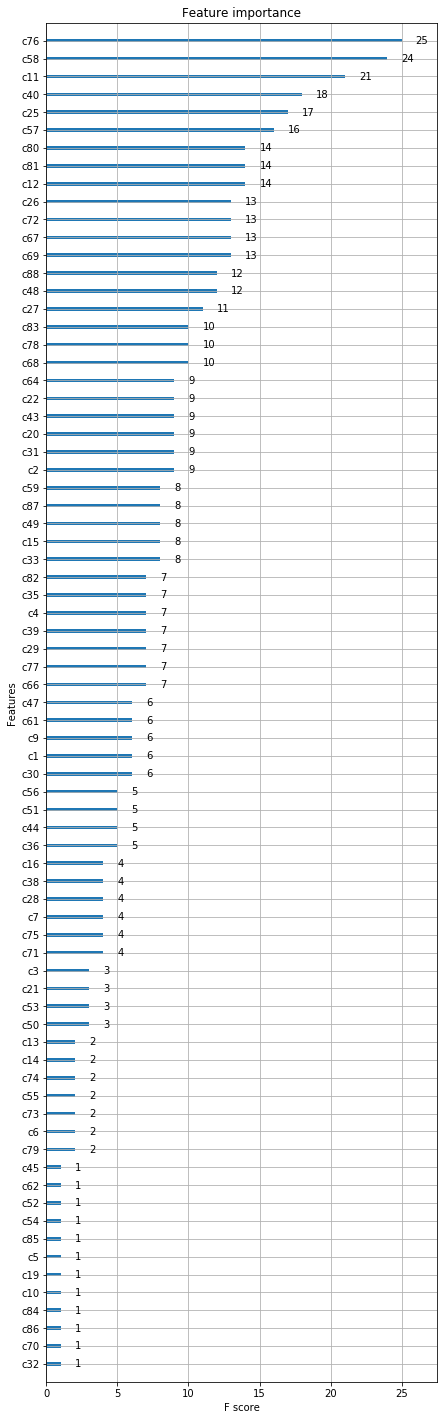

In [60]:
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=(7,25))
xgb.plot_importance(bst,ax=ax)

# 3 Predict

In [91]:
dfeature = xgb.DMatrix(feature.values, label=y.values, feature_names=feature_name)

train_predict_proba = bst.predict(dvalid)
print(train_predict_proba.shape)
train_predict

(112000,)


array([ 0.50609273,  0.48165104,  0.50415522, ...,  0.50249857,
        0.44578329,  0.50345904], dtype=float32)

In [92]:
test_feature = test[feature_name]
print(test_feature.shape)
test_feature.head()

(361500, 88)


Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x0000003E0F1E3DD8>>
Traceback (most recent call last):
  File "C:\Users\Mustang8\Anaconda3\lib\site-packages\xgboost-0.6-py3.6.egg\xgboost\core.py", line 360, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'


,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c79,c80,c81,c82,c83,c84,c85,c86,c87,c88
0,-0.336471,0.001629,-0.005328,0.337606,0.0,0.0,0.0,0.0,0.000779,-0.000000,...,0.078639,-0.121671,-0.007804,0.0,-0.261070,0.0,0.0,0.0,-0.002886,-0.999901
1,0.023397,0.010739,-0.035836,-0.017537,0.0,0.0,0.0,0.0,-0.003914,-0.656868,...,0.006190,0.071016,-0.008752,0.0,0.072960,0.0,0.0,0.0,-0.043107,1.056089
2,0.050958,0.012048,-0.004990,0.020966,-0.0,0.0,0.0,0.0,0.016245,-0.000000,...,-0.022399,-0.015489,-0.025594,0.0,0.046554,0.0,0.0,0.0,0.322360,1.506708
3,-0.123669,0.082726,-0.019575,0.000084,0.0,0.0,0.0,0.0,0.006868,-0.000000,...,0.004039,-0.086416,-0.002464,0.0,0.004583,0.0,0.0,0.0,0.022171,0.653286
4,1.596477,0.035155,-0.000731,0.028250,0.0,0.0,0.0,0.0,-0.025400,-0.000000,...,-0.056909,0.006886,-0.001491,0.0,0.082378,0.0,0.0,0.0,0.005997,-0.309680


In [94]:
dtest = xgb.DMatrix(test_feature.values,feature_names=feature_name)
test_predict =bst.predict(dtest)
print(test_predict.shape)
test_predict

(361500,)


array([ 0.48560041,  0.50397629,  0.50246352, ...,  0.50462013,
        0.50115353,  0.49429619], dtype=float32)

In [113]:
Predict =pd.DataFrame(test_predict)

In [121]:
predict = pd.concat((Test.data_id,Predict),axis =1)

In [123]:
predict = predict.reset_index(drop=True).copy()
print(predict.shape)
predict.head()

(361500, 2)


,data_id,0
0,1466096,0.485600
1,1466102,0.503976
2,1466110,0.502464
3,1466113,0.502791
4,1466115,0.500656


In [125]:
predict.to_csv("submission.csv",header=None,index=None)